# Sales Forecasting Description

## Step 0: Setup

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error , root_mean_squared_error
from sklearn.compose import ColumnTransformer
import joblib
import ipywidgets as widgets
from ipywidgets import interact


### Download Datasets

In [2]:
# --- 1. Download the dataset and define file paths ---
# This downloads the data and gives us the path to the directory
dataset_dir = kagglehub.dataset_download('aslanahmedov/walmart-sales-forecast')

# Construct the full path for each of the three files
train_path = f"{dataset_dir}/train.csv"
features_path = f"{dataset_dir}/features.csv"
stores_path = f"{dataset_dir}/stores.csv"

# Load the three CSV files into pandas DataFrames
train_df = pd.read_csv(train_path)
features_df = pd.read_csv(features_path)
stores_df = pd.read_csv(stores_path)

print("All three datasets loaded successfully.")


All three datasets loaded successfully.


### Merge Datasets

In [3]:
# --- 2. Prepare and merge the 'stores' data ---
stores_df.rename(columns={'Type': 'Store_Type', 'Size': 'Store_Size'}, inplace=True)
df = pd.merge(train_df, stores_df, on='Store', how='left')

In [4]:
# --- 3. Prepare and merge the 'features' data ---
# Merge the features; this will create 'IsHoliday_x' and 'IsHoliday_y'
df = pd.merge(df, features_df, on=['Store', 'Date'], how='left')

# The 'IsHoliday' column is in both train.csv and features.csv, creating a duplicate.
# We'll keep the first one ('IsHoliday_x') and remove the second ('IsHoliday_y').
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
df.drop(columns=['IsHoliday_y'], inplace=True)

In [5]:
# --- 4. Display the final results ---
print("\n--- Final Merged DataFrame ---")
print("\nFirst 5 rows:")
df.head(500000)


--- Final Merged DataFrame ---

First 5 rows:


,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Type,Store_Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


## Step 1: Data Cleaning

### Data Inspection

In [6]:
df.shape

(421570, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Store_Type    421570 non-null  object 
 6   Store_Size    421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [8]:
print("\nMissing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Store_Type           0
Store_Size           0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


In [9]:
# Count the total number of duplicate rows
duplicate_count = df.duplicated().sum()

print(f"There are {duplicate_count} duplicate rows in the DataFrame.")

There are 0 duplicate rows in the DataFrame.


### Drop Columns with Excessive Missing Values

In [10]:
df = df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

### Data Types Conversions & Lower Memory Usage

In [11]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d").astype('datetime64[s]')
df['IsHoliday'] = df['IsHoliday'].astype('uint8')
df['Store_Type'] = df['Store_Type'].map({'A':0, 'B':1, 'C':2}).astype('uint8')
df['Store_Size'] = df['Store_Size'].astype('uint32')
df['Store'] = df['Store'].astype('uint8')
df['Dept'] = df['Dept'].astype('uint8')
df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')
df['Temperature'] = df['Temperature'].astype('float32')
df['Fuel_Price'] = df['Fuel_Price'].astype('float32')
df['CPI'] = df['CPI'].astype('float32')
df['Unemployment'] = df['Unemployment'].astype('float32')

### Results after Cleaning

In [12]:
# Create a summary DataFrame to inspect the data
data_info = pd.DataFrame({
    'Column Name': df.columns,
    'Missing Values': df.isnull().sum(),
    'Data Type': df.dtypes
}).reset_index(drop=True)

# Display the summary table
print("DataFrame Inspection Summary:")
data_info

DataFrame Inspection Summary:


,Column Name,Missing Values,Data Type
0,Store,0,uint8
1,Dept,0,uint8
2,Date,0,datetime64[s]
3,Weekly_Sales,0,float32
4,IsHoliday,0,uint8
5,Store_Type,0,uint8
6,Store_Size,0,uint32
7,Temperature,0,float32
8,Fuel_Price,0,float32
9,CPI,0,float32


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype        
---  ------        --------------   -----        
 0   Store         421570 non-null  uint8        
 1   Dept          421570 non-null  uint8        
 2   Date          421570 non-null  datetime64[s]
 3   Weekly_Sales  421570 non-null  float32      
 4   IsHoliday     421570 non-null  uint8        
 5   Store_Type    421570 non-null  uint8        
 6   Store_Size    421570 non-null  uint32       
 7   Temperature   421570 non-null  float32      
 8   Fuel_Price    421570 non-null  float32      
 9   CPI           421570 non-null  float32      
 10  Unemployment  421570 non-null  float32      
dtypes: datetime64[s](1), float32(5), uint32(1), uint8(4)
memory usage: 14.5 MB


In [14]:
df.describe()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Type,Store_Size,Temperature,Fuel_Price,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31,15981.258789,0.070358,0.589912,136727.915739,60.090057,3.361026,171.201935,7.960289
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.939941,0.000000,0.000000,34875.000000,-2.060000,2.472000,126.064003,3.879000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.649902,0.000000,0.000000,93638.000000,46.680000,2.933000,132.022659,6.891000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.029785,0.000000,0.000000,140167.000000,62.090000,3.452000,182.318787,7.866000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852051,0.000000,1.000000,202505.000000,74.279999,3.738000,212.416992,8.572000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.375000,1.000000,2.000000,219622.000000,100.139999,4.468000,227.232803,14.313000
std,12.785297,30.492054,NaN,22711.183594,0.255750,0.666337,60980.583328,18.447931,0.458515,39.159275,1.863296


## Step 2: Feature Engineering

### Date-Based Features

In [15]:
df['Year'] = df['Date'].dt.year.astype('uint16')
df['Month'] = df['Date'].dt.month.astype('uint8')
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype('uint8')
#Day of week not used because all data is weekly and all days are wednesday

### Lag Features

In [16]:
# Ensure sorting for group operations
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Define group, target columns, and lags
grp = df.groupby(['Store', 'Dept'], sort=False)
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
spans = [1, 2, 4, 8, 13, 26, 52]

# Prepare results in a dict
new_cols = {}
for col in columns:
    for lag in spans:
        new_cols[f'{col}_lag_{lag}'] = grp[col].shift(lag)

# Add all at once → avoids fragmentation
df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

### EWMA Features

In [17]:
df = df.sort_values(['Store','Dept','Date']).reset_index(drop=True)
grp = df.groupby(['Store','Dept'], sort=False)

for col in columns:
    for span in spans:
            df[f'{col}_ewma_{span}'] = grp[col].transform(
                lambda s, span=span: s.shift(1).ewm(span=span, adjust=False).mean()
            ).astype('float32')

### Rolling Window Features

In [18]:
# prepare results in a dict
new_cols = {}

for col in columns:
    for w in spans:
        if w != 1 :  # rolling with window 1 is just the lagged value
            new_cols[f'{col}_roll_mean_{w}'] = grp[col].transform(
                lambda s: s.shift(1).rolling(window=w, min_periods=1).mean()
            ).astype('float32')

for col in columns:
    for w in spans:
        if w != 1 :  # rolling with window 1 is just the lagged value
            new_cols[f'{col}_roll_std_{w}'] = grp[col].transform(
                lambda s: s.shift(1).rolling(window=w, min_periods=1).std()
            ).astype('float32')

# concat once instead of inserting repeatedly
df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)


### Other Relevant Features

In [19]:
# 1. Create a helper DataFrame with unique rows for each Store and Date.
#    This represents the calendar for each store.
store_dates = df[['Store', 'Date', 'IsHoliday']].drop_duplicates().reset_index(drop=True)


# 2. Now, apply your original (and correct) logic to this new, clean DataFrame.
store_dates = store_dates.sort_values(["Store", "Date"])

store_dates["Holiday_Marker"] = store_dates["IsHoliday"].astype(int)
store_dates["Holiday_Group"] = store_dates.groupby("Store")["Holiday_Marker"].cumsum()

# This now correctly counts WEEKS (or whatever your Date frequency is) because there is one row per date.
store_dates["Weeks_Since_Last_Holiday"] = store_dates.groupby(["Store", "Holiday_Group"]).cumcount()


# 3. Merge the correct calculation back into your original DataFrame.
#    First, drop the incorrect column if it exists.
if 'Weeks_Since_Last_Holiday' in df.columns:
    df = df.drop(columns=['Weeks_Since_Last_Holiday'])

# Now merge the correct values.
df = pd.merge(
    df,
    store_dates[['Store', 'Date', 'Weeks_Since_Last_Holiday']],
    on=['Store', 'Date'],
    how='left'
)

# Convert to uint8 as the values are small
df['Weeks_Since_Last_Holiday'] = df['Weeks_Since_Last_Holiday'].astype('uint8')

In [20]:
# ---------- interactions (safe: use same-row or lagged inputs) ----------
df['IsHoliday_i'] = df['IsHoliday'].astype(int)

# ---------- safe week-level global baseline (method B) ----------
# 1) weekly mean across all stores (Year, WeekOfYear)
week_year = (
    df.groupby(['Year','WeekOfYear'])['Weekly_Sales']
      .mean()
      .reset_index(name='week_year_avg')
      .sort_values(['WeekOfYear','Year'])
)

# 2) expanding mean across years for same WeekOfYear -> FIXED VERSION
week_year = week_year.sort_values(['WeekOfYear', 'Year'])
week_year['avg_weekofyear_past'] = week_year.groupby('WeekOfYear')['week_year_avg'].transform(
    lambda x: x.expanding().mean().shift(1)
)

# 3) merge back
df = df.merge(week_year[['Year','WeekOfYear','avg_weekofyear_past']],
              on=['Year','WeekOfYear'], how='left')
df.rename(columns={'avg_weekofyear_past':'avg_sales_weekofyear_global_safe'}, inplace=True)

# ---------- dept-week baseline (Dept + WeekOfYear) using past years ----------
dept_week = (
    df.groupby(['Dept','WeekOfYear','Year'])['Weekly_Sales']
      .mean()
      .reset_index(name='dept_week_year_avg')
      .sort_values(['Dept','WeekOfYear','Year'])
)

# FIXED VERSION with transform
dept_week = dept_week.sort_values(['Dept', 'WeekOfYear', 'Year'])
dept_week['avg_deptweek_past'] = dept_week.groupby(['Dept','WeekOfYear'])['dept_week_year_avg'].transform(
    lambda x: x.expanding().mean().shift(1)
)

# merge back on Dept, Year, WeekOfYear
df = df.merge(dept_week[['Dept','Year','WeekOfYear','avg_deptweek_past']],
              on=['Dept','Year','WeekOfYear'], how='left')

# drop helper 'IsHoliday_i' if you want
df.drop(columns=['IsHoliday_i'], inplace=True)

In [21]:
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Type,Store_Size,Temperature,Fuel_Price,CPI,...,CPI_roll_std_52,Unemployment_roll_std_2,Unemployment_roll_std_4,Unemployment_roll_std_8,Unemployment_roll_std_13,Unemployment_roll_std_26,Unemployment_roll_std_52,Weeks_Since_Last_Holiday,avg_sales_weekofyear_global_safe,avg_deptweek_past
0,1,1,2010-02-05,24924.500000,0,0,151315,42.310001,2.572,211.096359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,1,2010-02-12,46039.488281,1,0,151315,38.509998,2.548,211.242172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,1,1,2010-02-19,41595.550781,0,0,151315,39.930000,2.514,211.289139,...,0.103105,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN
3,1,1,2010-02-26,19403.539062,0,0,151315,46.630001,2.561,211.319641,...,0.100525,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN,NaN
4,1,1,2010-03-05,21827.900391,0,0,151315,46.500000,2.625,211.350143,...,0.098918,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN,NaN


### Drop Rows with Missing Values
as they don't have enough historical data

In [22]:
# total rows
print("Total rows:", len(df))

# how many rows would be removed by a plain dropna()
print("Rows with any NaN (would be removed by df.dropna()):", df.isna().any(axis=1).sum())

# how many columns have NaNs and the counts
nan_counts = df.isna().sum().sort_values(ascending=False)
print(nan_counts[nan_counts>0].head(30))   # show top 30 columns with NaNs

# percent missing
print((nan_counts / len(df)).loc[lambda s: s>0].head(30))


Total rows: 421570
Rows with any NaN (would be removed by df.dropna()): 160487
Fuel_Price_lag_52                   160487
Temperature_lag_52                  160487
Weekly_Sales_lag_52                 160487
CPI_lag_52                          160487
Unemployment_lag_52                 160487
avg_deptweek_past                   152833
avg_sales_weekofyear_global_safe    152374
Fuel_Price_lag_26                    81918
Temperature_lag_26                   81918
Unemployment_lag_26                  81918
CPI_lag_26                           81918
Weekly_Sales_lag_26                  81918
Unemployment_lag_13                  41750
Temperature_lag_13                   41750
Fuel_Price_lag_13                    41750
CPI_lag_13                           41750
Weekly_Sales_lag_13                  41750
Weekly_Sales_lag_8                   25966
Unemployment_lag_8                   25966
Fuel_Price_lag_8                     25966
CPI_lag_8                            25966
Temperature_lag_8 

### Handle Remaining Missing Values

In [23]:
# Check the shape of your DataFrame before dropping
print(f"Shape before dropping NaNs: {df.shape}")

# Drop any row that contains at least one NaN value
df.dropna(inplace=True)

# Verify the new shape
print(f"Shape after dropping NaNs:  {df.shape}")

# Check if any nulls remain
print(f"\nRemaining null values: {df.isnull().sum().sum()}")

Shape before dropping NaNs: (421570, 147)
Shape after dropping NaNs:  (261083, 147)

Remaining null values: 0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Columns: 147 entries, Store to avg_deptweek_past
dtypes: datetime64[s](1), float32(135), float64(2), uint16(1), uint32(1), uint8(7)
memory usage: 145.7 MB


## Step 3 : Feature Selection

### Correlation Analysis with Weekly_Sales

In [25]:
# Calculate correlation between Weekly_Sales and all other numeric columns
correlations = df.corr()['Weekly_Sales'].drop('Weekly_Sales')  # Remove self-correlation

# Sort by absolute correlation values (highest to lowest)
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print("Correlation with Weekly_Sales (sorted by absolute correlation):")
print("=" * 60)
for feature, corr_value in correlations_sorted.items():
    print(f"{feature:<40}: {corr_value:>8.4f}")

print(f"\nTotal numeric features analyzed: {len(correlations_sorted)}")
print(f"Features with correlation > 0.1: {(correlations_sorted.abs() > 0.1).sum()}")
print(f"Features with correlation > 0.05: {(correlations_sorted.abs() > 0.05).sum()}")

Correlation with Weekly_Sales (sorted by absolute correlation):
Weekly_Sales_lag_52                     :   0.9809
Weekly_Sales_ewma_4                     :   0.9684
Weekly_Sales_ewma_8                     :   0.9669
Weekly_Sales_roll_mean_4                :   0.9669
Weekly_Sales_ewma_2                     :   0.9665
Weekly_Sales_ewma_13                    :   0.9646
Weekly_Sales_roll_mean_2                :   0.9644
Weekly_Sales_roll_mean_8                :   0.9619
Weekly_Sales_ewma_26                    :   0.9613
Weekly_Sales_ewma_1                     :   0.9600
Weekly_Sales_lag_1                      :   0.9600
Weekly_Sales_roll_mean_52               :   0.9594
Weekly_Sales_ewma_52                    :   0.9592
Weekly_Sales_roll_mean_13               :   0.9579
Weekly_Sales_roll_mean_26               :   0.9536
Weekly_Sales_lag_2                      :   0.9494
Weekly_Sales_lag_4                      :   0.9473
Weekly_Sales_lag_8                      :   0.9167
Weekly_Sales_lag_1

### Drop Low-Correlation Features to Reduce Dimensionality
Threshold = 0.05 , however, I will keep some features below this threshold if they seem potentially useful.

The following features have very low correlation (None is >=0.05) and thus can be considered for removal:

In [26]:
# All Temperature related features have low correlation with Weekly_Sales
# We can consider dropping them to reduce dimensionality
temp_features = [col for col in df.columns if 'Temperature' in col]
df.drop(columns=temp_features, inplace=True)

# All Fuel_Price related features have low correlation with Weekly_Sales
# We can consider dropping them to reduce dimensionality
fuel_features = [col for col in df.columns if 'Fuel' in col]
df.drop(columns=fuel_features, inplace=True)

# All Unemployment related features have low correlation with Weekly_Sales
# We can consider dropping them to reduce dimensionality
unemp_features = [col for col in df.columns if 'Unemployment' in col]
df.drop(columns=unemp_features, inplace=True)

# All CPI related features have low correlation with Weekly_Sales
# We can consider dropping them to reduce dimensionality
cpi_features = [col for col in df.columns if 'CPI' in col]
df.drop(columns=cpi_features, inplace=True)

In [27]:
df.shape

(261083, 39)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

In [29]:
# correlation matrix
corr = df.corr().round(3)

# style with absolute-value coloring and 2-decimal formatting
styled_corr = (
    corr.style
        .background_gradient(cmap="coolwarm", axis=None, gmap=corr.abs())
        .format(precision=2)
)

# save to HTML
styled_corr.to_html("correlation_matrix.html")
print("Saved styled correlation matrix to correlation_matrix.html")

display(styled_corr)

Saved styled correlation matrix to correlation_matrix.html


,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Type,Store_Size,Year,Month,WeekOfYear,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_4,Weekly_Sales_lag_8,Weekly_Sales_lag_13,Weekly_Sales_lag_26,Weekly_Sales_lag_52,Weekly_Sales_ewma_1,Weekly_Sales_ewma_2,Weekly_Sales_ewma_4,Weekly_Sales_ewma_8,Weekly_Sales_ewma_13,Weekly_Sales_ewma_26,Weekly_Sales_ewma_52,Weekly_Sales_roll_mean_2,Weekly_Sales_roll_mean_4,Weekly_Sales_roll_mean_8,Weekly_Sales_roll_mean_13,Weekly_Sales_roll_mean_26,Weekly_Sales_roll_mean_52,Weekly_Sales_roll_std_2,Weekly_Sales_roll_std_4,Weekly_Sales_roll_std_8,Weekly_Sales_roll_std_13,Weekly_Sales_roll_std_26,Weekly_Sales_roll_std_52,Weeks_Since_Last_Holiday,avg_sales_weekofyear_global_safe,avg_deptweek_past
Store,1.00,0.03,0.00,-0.08,-0.00,0.22,-0.18,0.00,0.00,0.00,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.09,-0.09,-0.09,-0.09,-0.09,-0.08,-0.09,-0.09,-0.09,-0.09,-0.09,-0.04,-0.06,-0.07,-0.07,-0.08,-0.09,0.00,-0.00,0.04
Dept,0.03,1.00,0.00,0.16,-0.00,0.01,-0.01,0.00,0.00,0.00,0.16,0.16,0.16,0.16,0.15,0.15,0.15,0.16,0.17,0.17,0.17,0.17,0.17,0.16,0.17,0.17,0.17,0.17,0.16,0.16,0.03,0.02,-0.02,-0.04,-0.06,-0.08,0.00,0.00,0.19
Date,0.00,0.00,1.00,-0.01,-0.02,0.01,-0.01,0.86,0.26,0.28,-0.00,0.00,0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,-0.03,-0.06,-0.06,-0.02,0.10,-0.08,-0.01
Weekly_Sales,-0.08,0.16,-0.01,1.00,0.01,-0.18,0.24,-0.01,0.02,0.02,0.96,0.95,0.95,0.92,0.90,0.89,0.98,0.96,0.97,0.97,0.97,0.96,0.96,0.96,0.96,0.97,0.96,0.96,0.95,0.96,0.36,0.45,0.44,0.43,0.44,0.49,-0.01,0.07,0.77
IsHoliday,-0.00,-0.00,-0.02,0.01,1.00,-0.00,0.00,-0.07,0.10,0.10,0.02,0.00,-0.01,0.01,-0.00,-0.00,0.01,0.02,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.01,0.01,0.00,-0.00,0.04,0.01,0.07,0.04,-0.00,0.00,-0.32,0.12,0.01
Store_Type,0.22,0.01,0.01,-0.18,-0.00,1.00,-0.81,0.01,0.00,0.00,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18,-0.19,-0.19,-0.19,-0.19,-0.18,-0.18,-0.19,-0.19,-0.19,-0.19,-0.08,-0.11,-0.12,-0.12,-0.14,-0.15,0.00,-0.00,0.05
Store_Size,-0.18,-0.01,-0.01,0.24,0.00,-0.81,1.00,-0.01,-0.00,-0.00,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.25,0.25,0.25,0.25,0.25,0.24,0.25,0.25,0.25,0.25,0.26,0.11,0.14,0.16,0.17,0.19,0.21,-0.00,0.00,-0.06
Year,0.00,0.00,0.86,-0.01,-0.07,0.01,-0.01,1.00,-0.26,-0.24,-0.01,-0.00,0.01,0.01,0.00,-0.00,-0.02,-0.01,-0.01,-0.00,0.00,0.00,0.00,-0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,-0.01,0.00,0.01,0.01,0.00,-0.02,0.03,-0.23,-0.03
Month,0.00,0.00,0.26,0.02,0.10,0.00,-0.00,-0.26,1.00,1.00,0.02,0.01,-0.00,-0.03,-0.03,-0.00,0.02,0.02,0.02,0.01,-0.00,-0.01,-0.01,-0.01,0.01,0.01,-0.01,-0.02,-0.01,-0.00,0.02,-0.00,-0.09,-0.13,-0.12,0.00,0.12,0.29,0.03
WeekOfYear,0.00,0.00,0.28,0.02,0.10,0.00,-0.00,-0.24,1.00,1.00,0.02,0.01,-0.01,-0.03,-0.03,-0.00,0.01,0.02,0.02,0.01,-0.00,-0.01,-0.01,-0.01,0.01,0.01,-0.01,-0.02,-0.01,-0.00,0.02,-0.00,-0.09,-0.13,-0.12,0.00,0.13,0.27,0.02


In [30]:
# 1. Get the upper triangle of the correlation matrix
upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 2. Unstack the matrix to get all correlation pairs
all_corr_pairs = upper_triangle.unstack().dropna()

# 3. Sort the pairs by their absolute correlation value
sorted_pairs = all_corr_pairs.sort_values(ascending=False, key=lambda x: x.abs())

# 4. Convert to a DataFrame for clean output
sorted_pairs_df = sorted_pairs.reset_index()
sorted_pairs_df.columns = ['F 1', 'F 2', 'Corr Value']

# --- The Key Part ---
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the DataFrame directly instead of printing it
sorted_pairs_df

,F 1,F 2,Corr Value
0,Weekly_Sales_ewma_1,Weekly_Sales_lag_1,1.000
1,Weekly_Sales_ewma_52,Weekly_Sales_ewma_26,0.999
2,Weekly_Sales_ewma_13,Weekly_Sales_ewma_8,0.999
3,Weekly_Sales_roll_mean_52,Weekly_Sales_ewma_52,0.998
4,Weekly_Sales_roll_mean_8,Weekly_Sales_ewma_8,0.998
5,Weekly_Sales_roll_mean_4,Weekly_Sales_ewma_4,0.998
6,Weekly_Sales_ewma_26,Weekly_Sales_ewma_13,0.998
7,Weekly_Sales_roll_mean_2,Weekly_Sales_ewma_2,0.998
8,Weekly_Sales_roll_mean_8,Weekly_Sales_ewma_13,0.998
9,Weekly_Sales_roll_mean_13,Weekly_Sales_ewma_13,0.998


### EWMA Features Correlation Matrix
#### Focusing on EWMA features as they showed higher correlation with Weekly_Sales

In [31]:
# 1. Identify all column names that contain 'ewma'
ewma_features = [col for col in df.columns if 'ewma' in col]

# 2. Create the final list of columns for the matrix
columns_for_matrix = ['Weekly_Sales'] + ewma_features

# 3. Create a subset DataFrame and calculate the full correlation matrix
ewma_corr_matrix = df[columns_for_matrix].corr().round(3)

# Display the final correlation matrix in your notebook
ewma_corr_matrix

,Weekly_Sales,Weekly_Sales_ewma_1,Weekly_Sales_ewma_2,Weekly_Sales_ewma_4,Weekly_Sales_ewma_8,Weekly_Sales_ewma_13,Weekly_Sales_ewma_26,Weekly_Sales_ewma_52
Weekly_Sales,1.000,0.960,0.966,0.968,0.967,0.965,0.961,0.959
Weekly_Sales_ewma_1,0.960,1.000,0.996,0.989,0.980,0.974,0.967,0.962
Weekly_Sales_ewma_2,0.966,0.996,1.000,0.997,0.991,0.985,0.978,0.973
Weekly_Sales_ewma_4,0.968,0.989,0.997,1.000,0.998,0.994,0.987,0.982
Weekly_Sales_ewma_8,0.967,0.980,0.991,0.998,1.000,0.999,0.995,0.990
Weekly_Sales_ewma_13,0.965,0.974,0.985,0.994,0.999,1.000,0.998,0.994
Weekly_Sales_ewma_26,0.961,0.967,0.978,0.987,0.995,0.998,1.000,0.999
Weekly_Sales_ewma_52,0.959,0.962,0.973,0.982,0.990,0.994,0.999,1.000


#### Analysis Results
EWMA_4 has the highest correlation (0.968) with target variable Weekly_Sales , I will keep it .

Also, EWMA_52  is excellent for capturing the yearly seasonal pattern , I will keep it as well.

I will drop the other EWMA features to reduce dimensionality and because they are highly correlated with each-other and the 2 kept features .

In [32]:
df.drop(columns=[col for col in df.columns if col in ['Weekly_Sales_ewma_1','Weekly_Sales_ewma_2','Weekly_Sales_ewma_8','Weekly_Sales_ewma_13','Weekly_Sales_ewma_26']], inplace=True)

In [33]:
df.shape

(261083, 34)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

### Lag Features Correlation Matrix

In [35]:
lag_features = [col for col in df.columns if 'Weekly_Sales_lag_' in col]

# 2. Create the list of columns for the matrix
columns_for_matrix = ['Weekly_Sales'] + lag_features

# 3. Create a subset DataFrame and calculate the correlation matrix
lag_corr_matrix = df[columns_for_matrix].corr().round(3)

# Display the final correlation matrix in your notebook
lag_corr_matrix

,Weekly_Sales,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_4,Weekly_Sales_lag_8,Weekly_Sales_lag_13,Weekly_Sales_lag_26,Weekly_Sales_lag_52
Weekly_Sales,1.000,0.960,0.949,0.947,0.917,0.899,0.892,0.981
Weekly_Sales_lag_1,0.960,1.000,0.960,0.943,0.916,0.899,0.889,0.945
Weekly_Sales_lag_2,0.949,0.960,1.000,0.949,0.915,0.901,0.887,0.939
Weekly_Sales_lag_4,0.947,0.943,0.949,1.000,0.932,0.905,0.888,0.941
Weekly_Sales_lag_8,0.917,0.916,0.915,0.932,1.000,0.900,0.878,0.909
Weekly_Sales_lag_13,0.899,0.899,0.901,0.905,0.900,1.000,0.875,0.892
Weekly_Sales_lag_26,0.892,0.889,0.887,0.888,0.878,0.875,1.000,0.885
Weekly_Sales_lag_52,0.981,0.945,0.939,0.941,0.909,0.892,0.885,1.000


#### Analysis Results
Lag_52 has the highest correlation (0.981) with target variable Weekly_Sales , I will keep it .

Also, Lag_1  is excellent for capturing recent trend , I will keep it as well.

I will drop the other Lag features to reduce dimensionality and because they are highly correlated with each-other and the 2 features remaining.

In [36]:
df.drop(columns=[col for col in df.columns if col in ['Weekly_Sales_lag_2','Weekly_Sales_lag_4','Weekly_Sales_lag_8','Weekly_Sales_lag_13','Weekly_Sales_lag_26']], inplace=True)

In [37]:
df.shape

(261083, 29)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

### Rolling Mean Features Correlation Matrix

In [39]:
# 1. Find all column names for Weekly_Sales rolling means
roll_mean_features = [col for col in df.columns if 'Weekly_Sales_roll_mean_' in col]

# 2. Create the list of columns for the matrix
columns_for_matrix = ['Weekly_Sales'] + roll_mean_features

# 3. Create a subset and calculate the correlation matrix
roll_mean_corr_matrix = df[columns_for_matrix].corr().round(3)

# Display the final correlation matrix
roll_mean_corr_matrix

,Weekly_Sales,Weekly_Sales_roll_mean_2,Weekly_Sales_roll_mean_4,Weekly_Sales_roll_mean_8,Weekly_Sales_roll_mean_13,Weekly_Sales_roll_mean_26,Weekly_Sales_roll_mean_52
Weekly_Sales,1.000,0.964,0.967,0.962,0.958,0.954,0.959
Weekly_Sales_roll_mean_2,0.964,1.000,0.992,0.983,0.975,0.968,0.969
Weekly_Sales_roll_mean_4,0.967,0.992,1.000,0.993,0.985,0.976,0.977
Weekly_Sales_roll_mean_8,0.962,0.983,0.993,1.000,0.995,0.985,0.982
Weekly_Sales_roll_mean_13,0.958,0.975,0.985,0.995,1.000,0.992,0.986
Weekly_Sales_roll_mean_26,0.954,0.968,0.976,0.985,0.992,1.000,0.994
Weekly_Sales_roll_mean_52,0.959,0.969,0.977,0.982,0.986,0.994,1.000


#### Analysis Results
roll_mean_4 has the highest correlation (0.967) with target variable Weekly_Sales , I will keep it .

Also, roll_mean_52  is excellent for capturing the yearly seasonal pattern , I will keep it as well.

I will drop the other roll_mean features to reduce dimensionality and because they are highly correlated with each-other and the 2 features remaining.

In [40]:
df.drop(columns=[col for col in df.columns if col in ['Weekly_Sales_roll_mean_1','Weekly_Sales_roll_mean_2','Weekly_Sales_roll_mean_8','Weekly_Sales_roll_mean_13','Weekly_Sales_roll_mean_26']], inplace=True)

In [41]:
df.shape

(261083, 25)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

### Rolling Std Features Correlation Matrix

In [43]:
# 1. Find all column names for Weekly_Sales rolling std
roll_std_features = [col for col in df.columns if 'Weekly_Sales_roll_std_' in col]

# 2. Create the list of columns for the matrix
columns_for_matrix = ['Weekly_Sales'] + roll_std_features

# 3. Create a subset and calculate the correlation matrix
roll_std_corr_matrix = df[columns_for_matrix].corr().round(3)

# Display the final correlation matrix
roll_std_corr_matrix

,Weekly_Sales,Weekly_Sales_roll_std_2,Weekly_Sales_roll_std_4,Weekly_Sales_roll_std_8,Weekly_Sales_roll_std_13,Weekly_Sales_roll_std_26,Weekly_Sales_roll_std_52
Weekly_Sales,1.000,0.364,0.447,0.438,0.431,0.437,0.491
Weekly_Sales_roll_std_2,0.364,1.000,0.740,0.578,0.478,0.384,0.363
Weekly_Sales_roll_std_4,0.447,0.740,1.000,0.775,0.644,0.517,0.473
Weekly_Sales_roll_std_8,0.438,0.578,0.775,1.000,0.851,0.671,0.572
Weekly_Sales_roll_std_13,0.431,0.478,0.644,0.851,1.000,0.797,0.654
Weekly_Sales_roll_std_26,0.437,0.384,0.517,0.671,0.797,1.000,0.821
Weekly_Sales_roll_std_52,0.491,0.363,0.473,0.572,0.654,0.821,1.000


#### Analysis Results
The highest correlation is only 0.491 (for roll_std_52) , which is quite low compared to EWMA , Lag , and Rolling Mean features.

I will drop all Rolling Std features to reduce dimensionality.

In [44]:
df.drop(columns=[col for col in df.columns if col in roll_std_features], inplace=True)

In [45]:
df.shape

(261083, 19)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

### Final Correlation Matrix

In [47]:
# correlation matrix
corr = df.corr().round(3)

# style with absolute-value coloring and 2-decimal formatting
styled_corr = (
    corr.style
        .background_gradient(cmap="coolwarm", axis=None, gmap=corr.abs())
        .format(precision=2)
)

# save to HTML
styled_corr.to_html("correlation_matrix.html")
print("Saved styled correlation matrix to correlation_matrix.html")

display(styled_corr)

Saved styled correlation matrix to correlation_matrix.html


,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Type,Store_Size,Year,Month,WeekOfYear,Weekly_Sales_lag_1,Weekly_Sales_lag_52,Weekly_Sales_ewma_4,Weekly_Sales_ewma_52,Weekly_Sales_roll_mean_4,Weekly_Sales_roll_mean_52,Weeks_Since_Last_Holiday,avg_sales_weekofyear_global_safe,avg_deptweek_past
Store,1.00,0.03,0.00,-0.08,-0.00,0.22,-0.18,0.00,0.00,0.00,-0.08,-0.08,-0.09,-0.09,-0.09,-0.09,0.00,-0.00,0.04
Dept,0.03,1.00,0.00,0.16,-0.00,0.01,-0.01,0.00,0.00,0.00,0.16,0.15,0.17,0.16,0.17,0.16,0.00,0.00,0.19
Date,0.00,0.00,1.00,-0.01,-0.02,0.01,-0.01,0.86,0.26,0.28,-0.00,-0.01,-0.00,-0.01,0.00,-0.00,0.10,-0.08,-0.01
Weekly_Sales,-0.08,0.16,-0.01,1.00,0.01,-0.18,0.24,-0.01,0.02,0.02,0.96,0.98,0.97,0.96,0.97,0.96,-0.01,0.07,0.77
IsHoliday,-0.00,-0.00,-0.02,0.01,1.00,-0.00,0.00,-0.07,0.10,0.10,0.02,0.01,0.01,0.00,0.00,-0.00,-0.32,0.12,0.01
Store_Type,0.22,0.01,0.01,-0.18,-0.00,1.00,-0.81,0.01,0.00,0.00,-0.18,-0.18,-0.18,-0.19,-0.18,-0.19,0.00,-0.00,0.05
Store_Size,-0.18,-0.01,-0.01,0.24,0.00,-0.81,1.00,-0.01,-0.00,-0.00,0.24,0.24,0.25,0.25,0.25,0.26,-0.00,0.00,-0.06
Year,0.00,0.00,0.86,-0.01,-0.07,0.01,-0.01,1.00,-0.26,-0.24,-0.01,-0.02,-0.00,-0.00,-0.00,-0.00,0.03,-0.23,-0.03
Month,0.00,0.00,0.26,0.02,0.10,0.00,-0.00,-0.26,1.00,1.00,0.02,0.02,0.01,-0.01,0.01,-0.00,0.12,0.29,0.03
WeekOfYear,0.00,0.00,0.28,0.02,0.10,0.00,-0.00,-0.24,1.00,1.00,0.02,0.01,0.01,-0.01,0.01,-0.00,0.13,0.27,0.02


In [48]:
df.shape

(261083, 19)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261083 entries, 52 to 421569
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype        
---  ------                            --------------   -----        
 0   Store                             261083 non-null  uint8        
 1   Dept                              261083 non-null  uint8        
 2   Date                              261083 non-null  datetime64[s]
 3   Weekly_Sales                      261083 non-null  float32      
 4   IsHoliday                         261083 non-null  uint8        
 5   Store_Type                        261083 non-null  uint8        
 6   Store_Size                        261083 non-null  uint32       
 7   Year                              261083 non-null  uint16       
 8   Month                             261083 non-null  uint8        
 9   WeekOfYear                        261083 non-null  uint8        
 10  Weekly_Sales_lag_1                261083 non-nul

## Step 4 : Data Preparation

#### Scaling and Encoding

In [50]:
# --- 1. Prepare Your Data ---

# Use the entire DataFrame and drop the target and any non-numerical columns
X = df.drop(columns=['Weekly_Sales', 'Date'])
y = df['Weekly_Sales']

# Identify categorical columns to be one-hot encoded
# Even though they are uint8, they represent categories
categorical_cols = ['Store', 'Dept', 'Store_Type', 'IsHoliday']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 2. Scale the Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"PCA is being performed on {X_scaled.shape[1]} features...")


PCA is being performed on 135 features...


#### Detect optimized number PCA of components

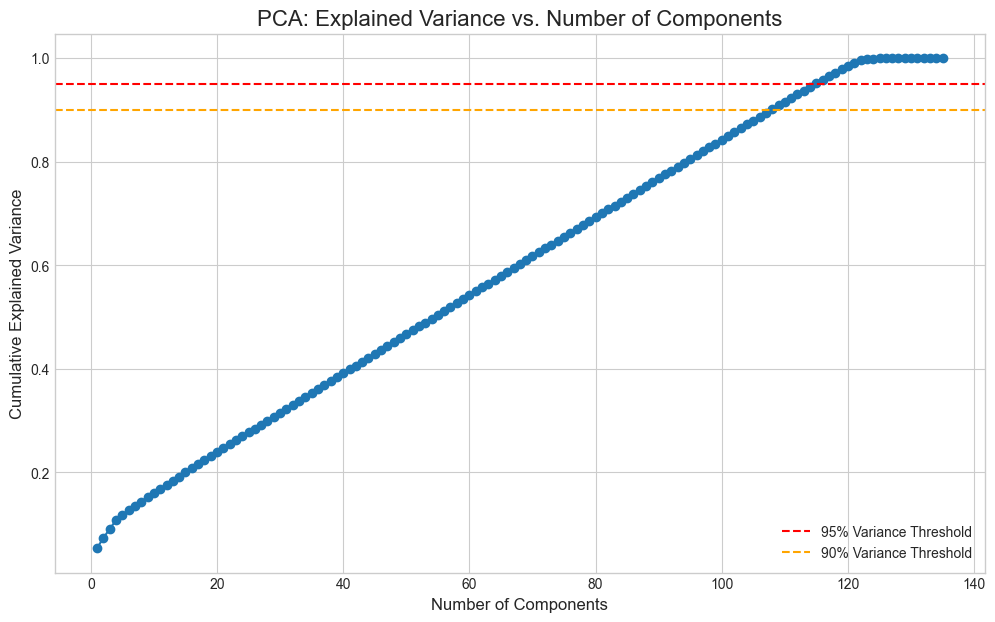

In [51]:
# --- 3. Perform PCA ---
pca = PCA(n_components=None)
pca.fit(X_scaled)

# --- 4. Plot Cumulative Variance ---
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA: Explained Variance vs. Number of Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)

# Add a line for the 95% variance threshold
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend(loc='best')
plt.grid(True)

# Add a line for the 90% Variance threshold
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% Variance Threshold')
plt.legend(loc='best')
plt.grid(True)

plt.show()

In [52]:
# Create a pandas Series for easier viewing, with index starting at 1
variance_series = pd.Series(cumulative_variance,
                            index=range(1, len(cumulative_variance) + 1))

# Select the range you're interested in (from 100 to 135 components)
detailed_variance = variance_series.loc[100:135]

# Convert it to a DataFrame for a clean table view
variance_table = detailed_variance.to_frame(name='Cumulative Variance')
variance_table.index.name = 'Number of Components'

# Display the detailed table
print(variance_table.to_string())

                      Cumulative Variance
Number of Components                     
100                              0.842355
101                              0.849778
102                              0.857181
103                              0.864567
104                              0.871948
105                              0.879301
106                              0.886618
107                              0.893893
108                              0.901158
109                              0.908413
110                              0.915658
111                              0.922853
112                              0.929965
113                              0.937050
114                              0.944086
115                              0.951104
116                              0.957984
117                              0.964826
118                              0.971619
119                              0.978292
120                              0.984839
121                              0

I will choose 115 Components as it preserves 95% of the explained variance.

In [53]:
# Set your final number of components
N_COMPONENTS = 115

# 1. Initialize PCA with 115 components
pca = PCA(n_components=N_COMPONENTS)

# 2. Fit PCA on the scaled data and then transform it
X_pca = pca.fit_transform(X_scaled)

# 3. Create a new DataFrame with the principal components
# This is the final feature set to use for training your model
pca_df = pd.DataFrame(data=X_pca,
                      columns=[f'PC_{i+1}' for i in range(N_COMPONENTS)])

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features: {pca_df.shape[1]}")

print("\nFirst 5 rows of your new PCA-transformed feature set:")
pca_df.head()

Original number of features: 135
Reduced number of features: 115

First 5 rows of your new PCA-transformed feature set:


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_106,PC_107,PC_108,PC_109,PC_110,PC_111,PC_112,PC_113,PC_114,PC_115
0,0.612532,0.433047,-1.392399,0.429643,-0.776407,0.217508,-0.001826,-0.118992,0.057118,0.034641,...,0.003260,0.075027,-0.098161,-0.040985,0.058157,0.016312,0.020759,-0.239031,0.169559,0.064902
1,1.264865,0.251134,-1.006693,0.272817,-3.846247,0.216153,-0.003391,-0.074136,0.040722,-0.005931,...,0.051100,0.042558,-0.003537,0.013719,0.045487,0.077586,0.063721,-0.106724,0.122902,0.037119
2,1.509000,0.354537,-1.416817,0.506003,-1.036241,0.185071,-0.004046,-0.089055,0.035778,0.027225,...,0.001938,0.069072,-0.087593,-0.030951,0.051822,0.001451,0.008594,-0.204480,0.118647,0.061275
3,1.383656,0.486174,-1.620917,0.590256,-0.836547,0.073790,-0.019662,0.000874,-0.034049,0.018355,...,-0.009806,0.061484,-0.073955,-0.012386,0.037504,-0.032218,-0.020280,-0.144013,0.014889,0.046848
4,0.924871,0.452502,-1.239327,0.345927,-0.799842,0.141448,-0.013117,-0.050122,0.007452,0.024464,...,-0.002779,0.064207,-0.078485,-0.021975,0.042470,-0.011942,-0.000227,-0.172799,0.081593,0.050048


## Step 5 : Regression with XGBOOST

In [54]:
# --- 1. Split into Training and Testing Sets ---
# IMPORTANT: For time series, we set shuffle=False!
X_train, X_test, y_train, y_test = train_test_split(
    pca_df, y, test_size=0.2, shuffle=False
)

# --- 2. Initialize and Train the XGBoost Regressor Model ---
# These are strong starting parameters for the model
xgbr = xgb.XGBRegressor(
    n_estimators=1000,         # Number of boosting rounds
    learning_rate=0.05,        # Step size shrinkage
    objective='reg:squarederror',
    early_stopping_rounds=50,  # Stop if validation score doesn't improve
    n_jobs=-1                  # Use all available CPU cores
)

print("Training XGBoost model...")

# We use the test set as the evaluation set for early stopping
xgbr.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Set to True if you want to see the training progress
)

print("Model training complete.")

# --- 3. Make Predictions and Evaluate ---
predictions = xgbr.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print(f"\n--- Model Performance ---")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")

Training XGBoost model...
Model training complete.

--- Model Performance ---
Mean Absolute Error (MAE): 1,711.38
Root Mean Squared Error (RMSE): 3,285.36
Mean Squared Error (MSE): 10,793,615.00


### Visualizing the plots

In [55]:
## available results to plot

In [56]:
import pandas as pd
import numpy as np

# Assume df, y_test, and predictions are already defined
results_df = y_test.to_frame(name='Actual')
results_df['Predicted'] = predictions
results_df['Date'] = df.loc[y_test.index, 'Date']
results_df['Store'] = df.loc[y_test.index, 'Store']
results_df['Dept'] = df.loc[y_test.index, 'Dept']


# --- The New Investigation with RMSE ---

# 1. Calculate the squared error for each row. This is the basis for RMSE.
# RMSE = sqrt(mean( (actual - predicted)^2 ))
results_df['SquaredError'] = (results_df['Actual'] - results_df['Predicted']) ** 2

# 2. Group by Store and Dept, then aggregate to get the count and the mean squared error.
grouped_analysis = results_df.groupby(['Store', 'Dept']).agg(
    RowCount=('Store', 'size'), # 'size' counts every row in the group
    MeanSquaredError=('SquaredError', 'mean') # Calculate the mean of our squared errors
)

# 3. Calculate the RMSE by taking the square root of the mean squared error.
grouped_analysis['RMSE'] = np.sqrt(grouped_analysis['MeanSquaredError'])

# 4. Clean up the table for a tidy view
# We can drop the intermediate MeanSquaredError column and sort by the row count.
final_stats = grouped_analysis.drop(columns=['MeanSquaredError'])
final_stats = final_stats.sort_values(by='RowCount', ascending=False)


# --- Display the results ---
print("Available Store/Dept combinations with Row Count and RMSE:")
print(final_stats.head(1000))

Available Store/Dept combinations with Row Count and RMSE:
            RowCount          RMSE
Store Dept                        
45    97          91    734.494995
      95          91   3890.745361
35    42          91   1133.371948
      44          91   1174.758423
45    67          91   2232.911377
      60          91    127.176521
      59          91    422.721527
      56          91   2713.055664
      55          91   1488.264282
      52          91    339.091827
      46          91   1977.065918
      44          91    512.970886
      42          91    677.977539
      41          91   1304.285156
      40          91   2118.096191
      38          91   6395.282227
      36          91    987.901611
36    4           91    627.802795
      3           91   1966.236450
      2           91   3693.258789
      1           91   1932.961426
35    97          91    805.808594
      95          91   5741.976074
      93          91    654.081299
      92          91   5127.197

### Best Performing Store/Dept Combinations Based on RMSE

In [63]:
def plot_sales_for_store_dept(df, store_id, dept_id):
    """
    Filters a DataFrame for a specific store and department, then plots
    actual vs. predicted sales over time.
    """
    # Filter for the specific combination
    results_subset = df[
        (df['Store'] == store_id) &
        (df['Dept'] == dept_id)
    ]

    # Check if the subset is empty
    if results_subset.empty:
        print(f"⚠️ No data found for Store {store_id}, Dept {dept_id}. Plot skipped.")
        return # Exit the function

    # Sort by date to ensure the line plot connects points chronologically
    results_subset = results_subset.sort_values(by='Date')

    # Plot this specific subset
    ax = results_subset.plot(
        x='Date',
        y=['Actual', 'Predicted'],
        kind='line',
        style=['-','--'], # Solid line for Actual, dashed for Predicted
        figsize=(16, 8),
        title=f'Actual vs. Predicted Sales for Store {store_id}, Dept {dept_id}'
    )
    ax.set_ylabel('Weekly Sales')
    ax.set_xlabel('Date')
    ax.grid(True)
    ax.legend()
    plt.show()

# Get valid Store/Dept combinations from the actual data
valid_combinations = results_df[['Store', 'Dept']].drop_duplicates().sort_values(['Store', 'Dept'])

# Create a list of tuples for the dropdown options
# Format: "Store X, Dept Y" for display, (store, dept) as value
combination_options = []
for _, row in valid_combinations.iterrows():
    store, dept = row['Store'], row['Dept']
    display_text = f"Store {store}, Dept {dept}"
    combination_options.append((display_text, (store, dept)))

print(f'Available combinations: {len(combination_options)} valid Store/Dept pairs')
print('Select from the dropdown below:')

# Create the interactive widget with valid combinations only
def plot_wrapper(combination):
    """Wrapper function to unpack the store and dept from the selected combination"""
    store, dept = combination
    plot_sales_for_store_dept(results_df, store, dept)

interact(
    plot_wrapper,
    combination=widgets.Dropdown(
        options=combination_options,
        description='Store/Dept:',
        style={'description_width': 'initial'},
        layout={'width': '300px'}
    )
);

Available combinations: 614 valid Store/Dept pairs
Select from the dropdown below:


interactive(children=(Dropdown(description='Store/Dept:', layout=Layout(width='300px'), options=(('Store 35, D…

Store/Dept combinations with at least 90 rows: 519
✅ Found sufficient combinations. Showing top 10.

Top 10 Best Performing Store/Dept Combinations (Lowest RMSE, Min 90 rows):
Store 45, Dept 60: RMSE = 127.18, Row Count =  91
Store 37, Dept 28: RMSE = 148.63, Row Count =  91
Store 42, Dept 28: RMSE = 164.65, Row Count =  91
Store 40, Dept 60: RMSE = 172.49, Row Count =  91
Store 44, Dept 60: RMSE = 176.86, Row Count =  91
Store 38, Dept 60: RMSE = 184.01, Row Count =  91
Store 44, Dept 21: RMSE = 196.60, Row Count =  91
Store 36, Dept 60: RMSE = 198.36, Row Count =  91
Store 38, Dept 28: RMSE = 200.44, Row Count =  91
Store 40, Dept 27: RMSE = 207.65, Row Count =  91

Plotting actual vs predicted sales for the top 10 performers...


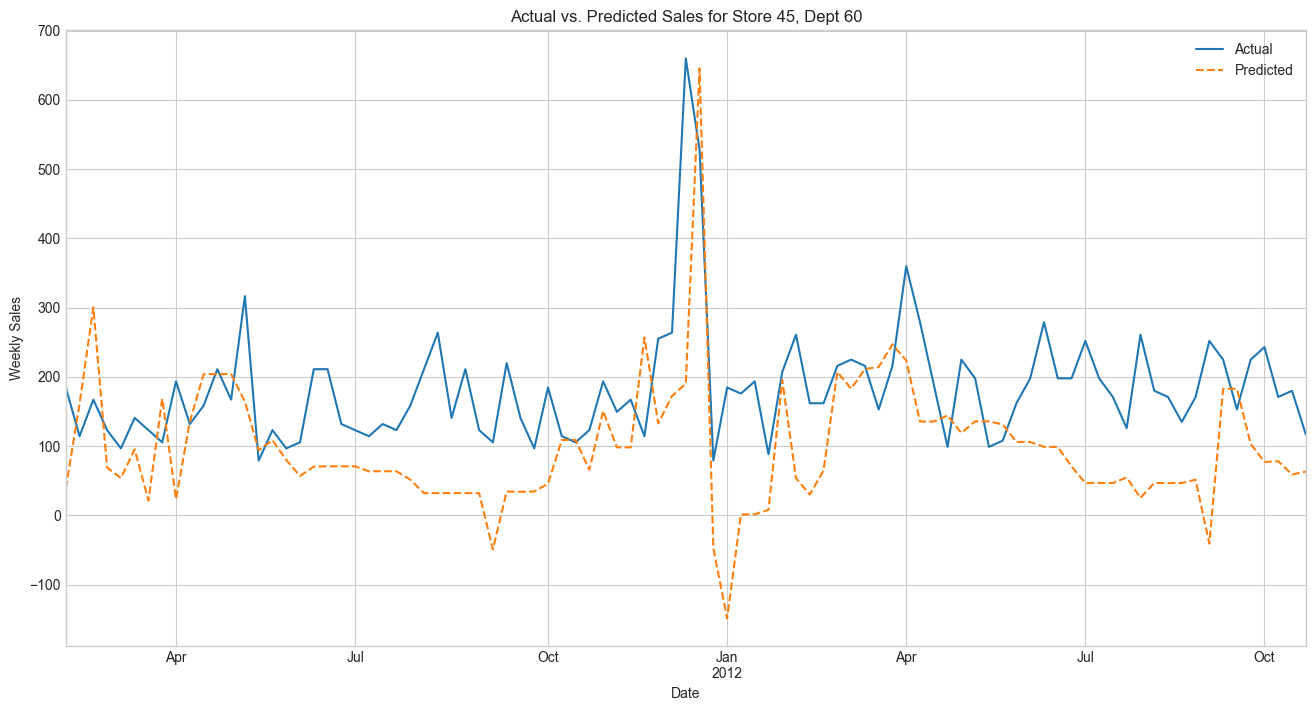

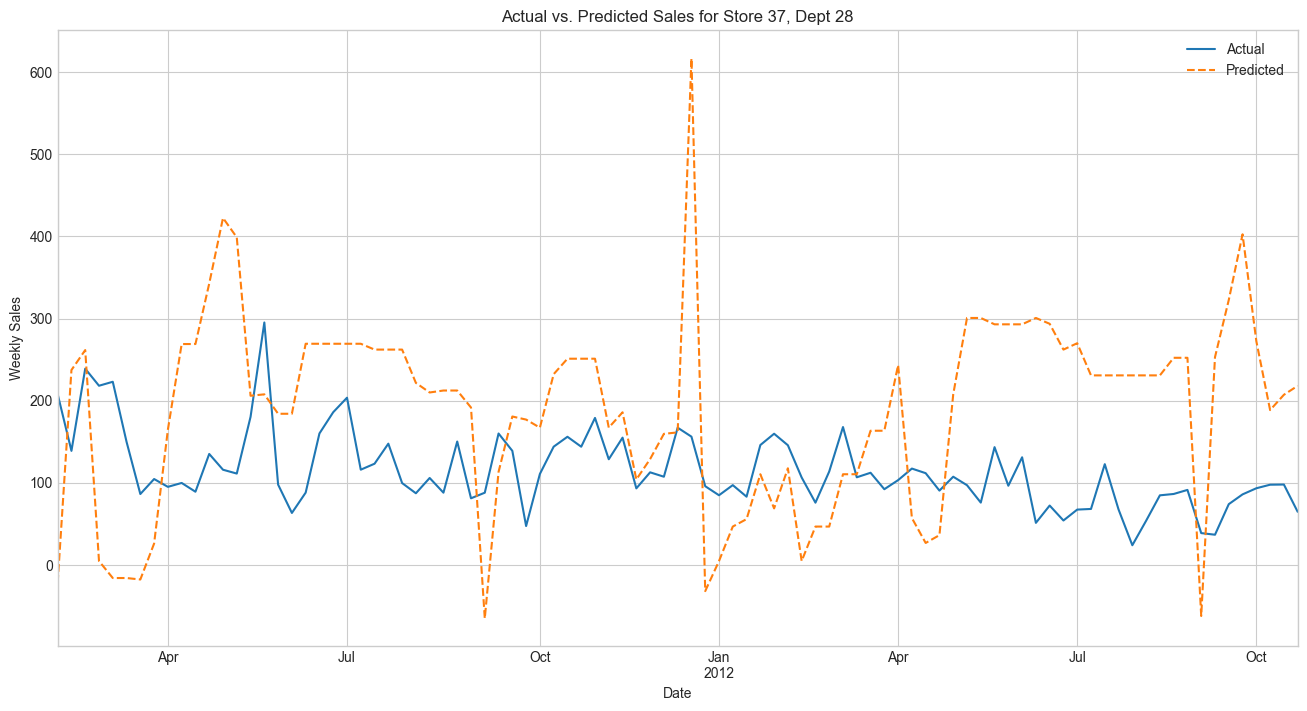

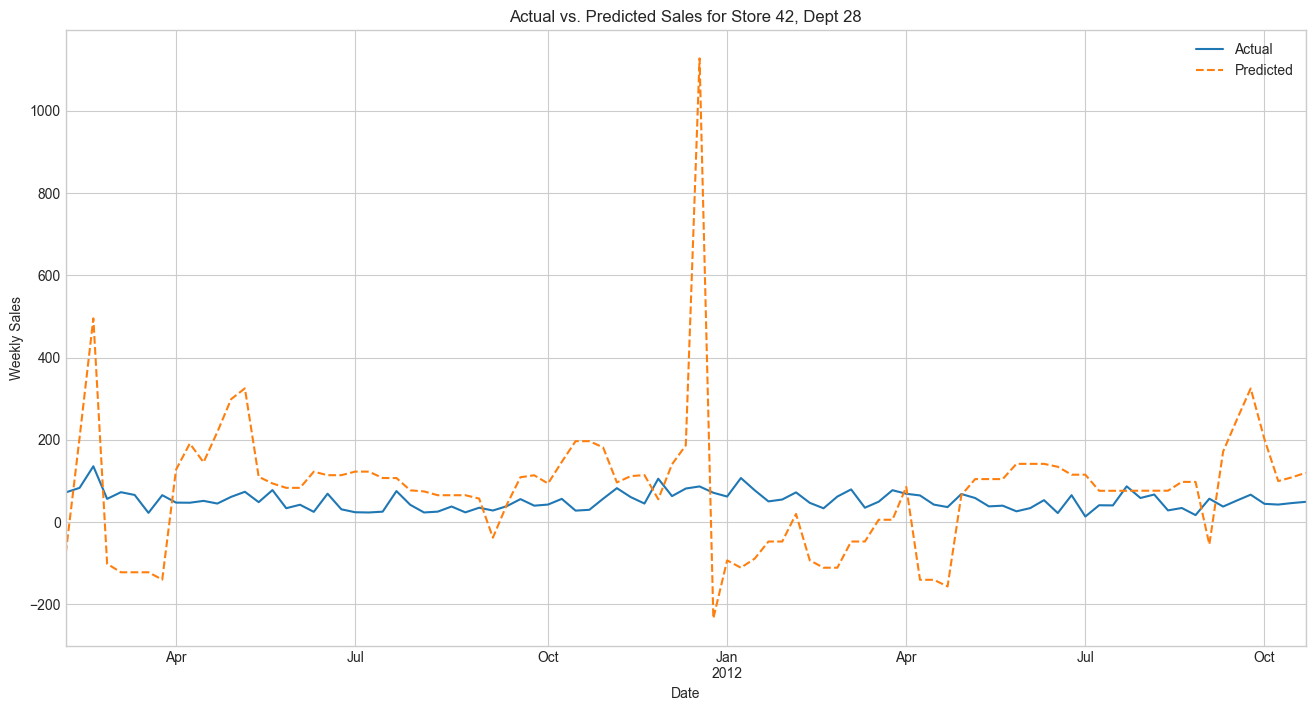

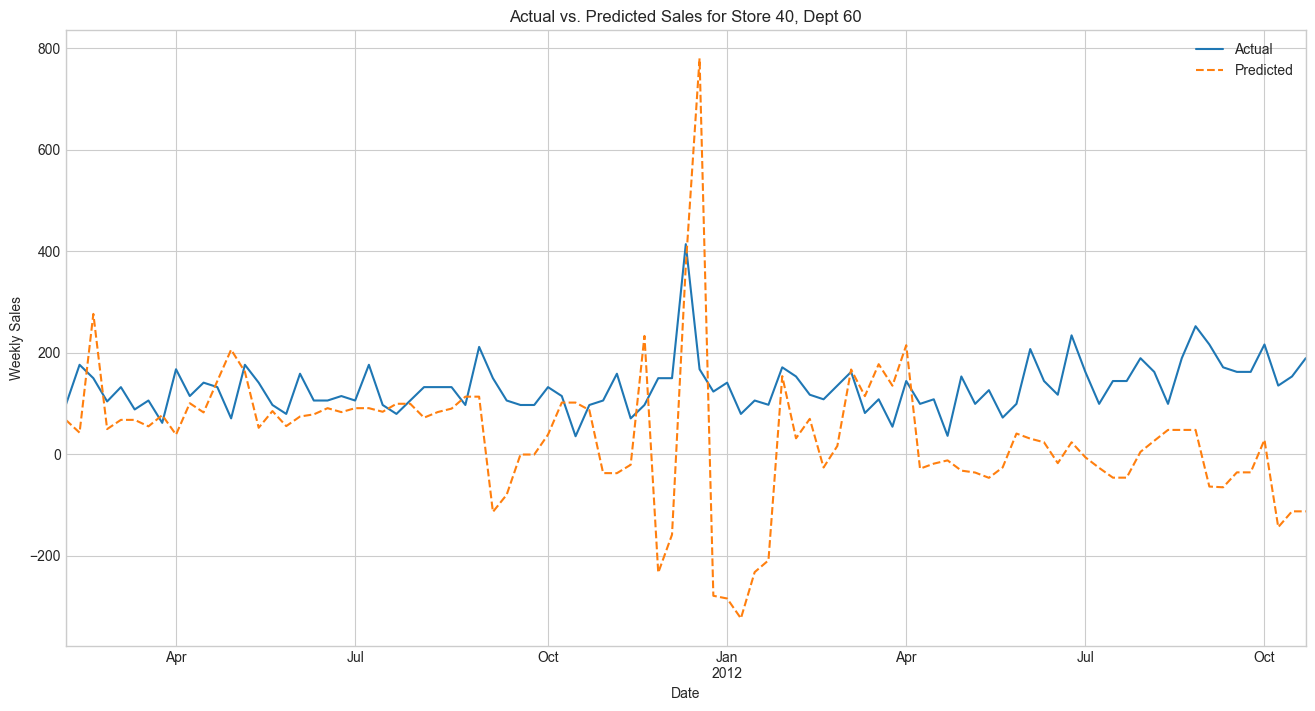

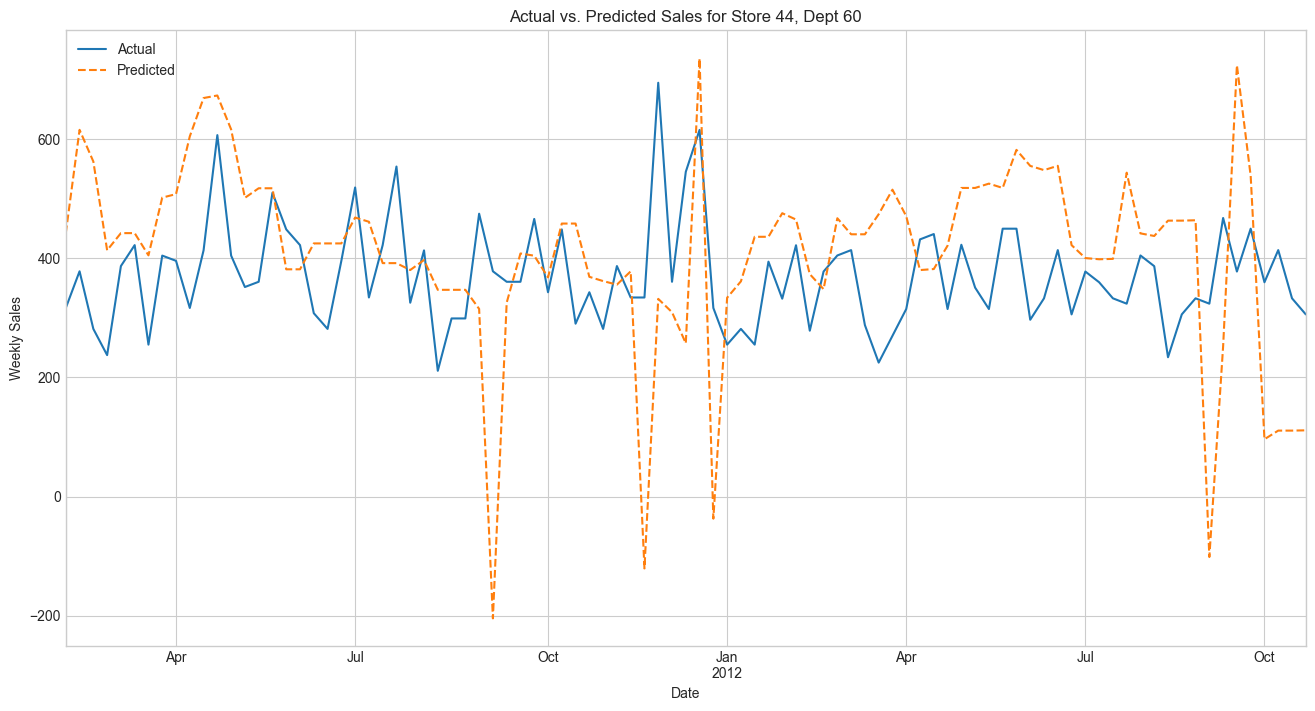

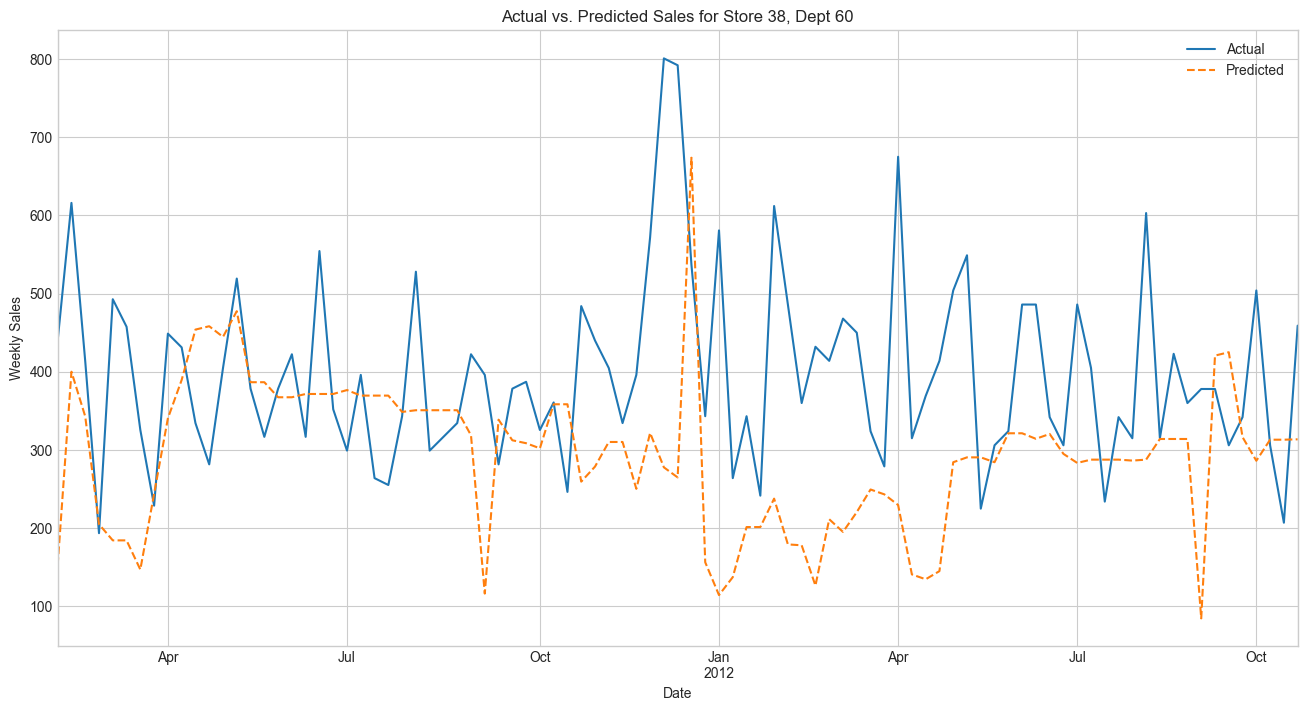

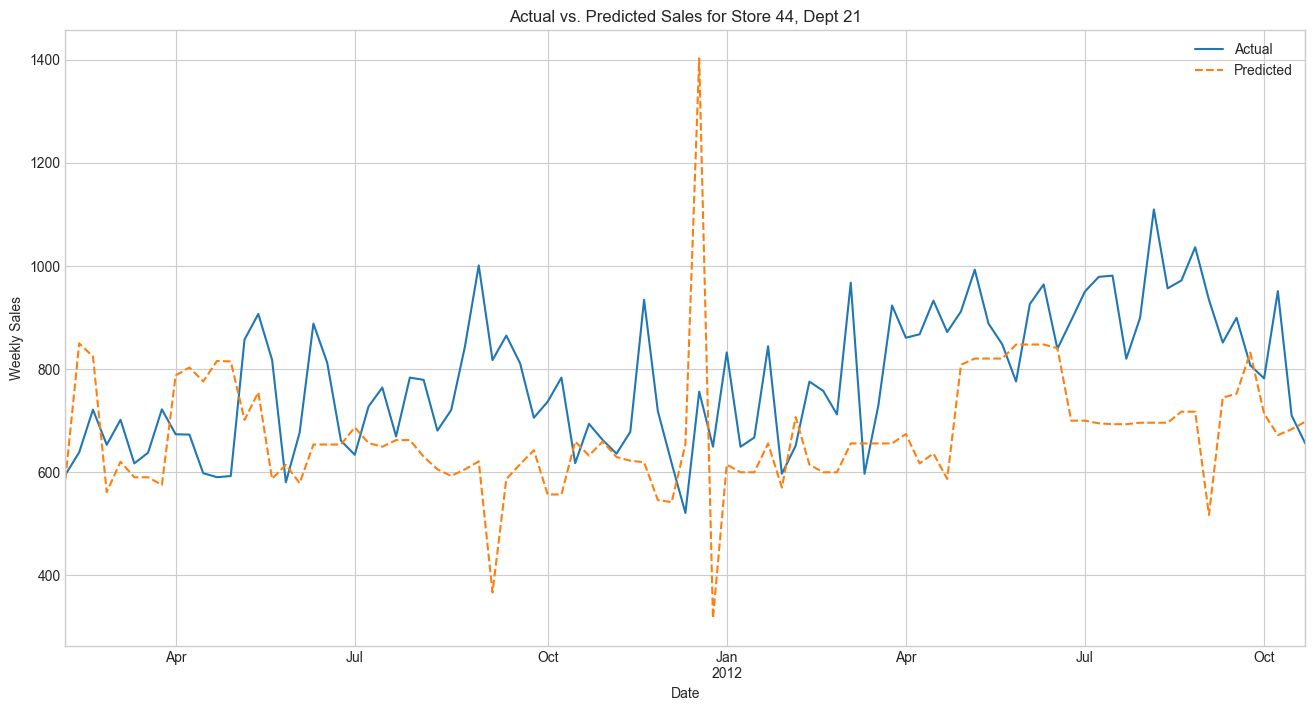

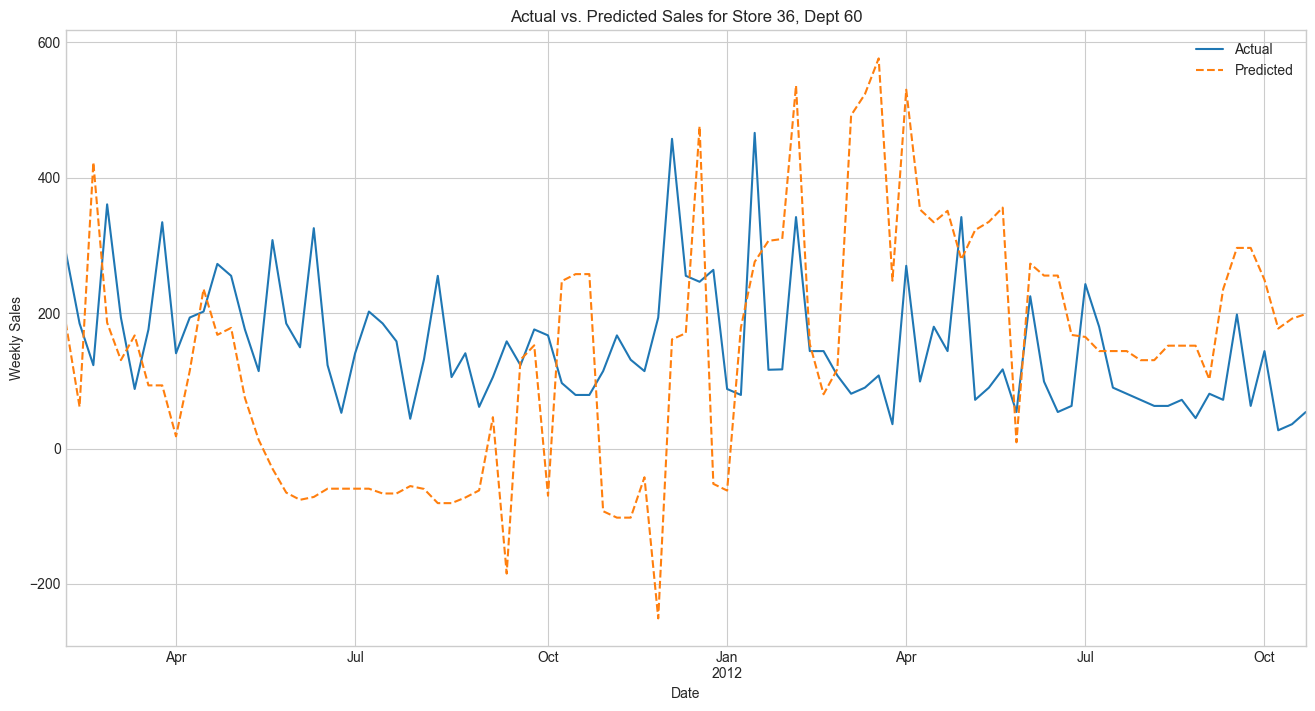

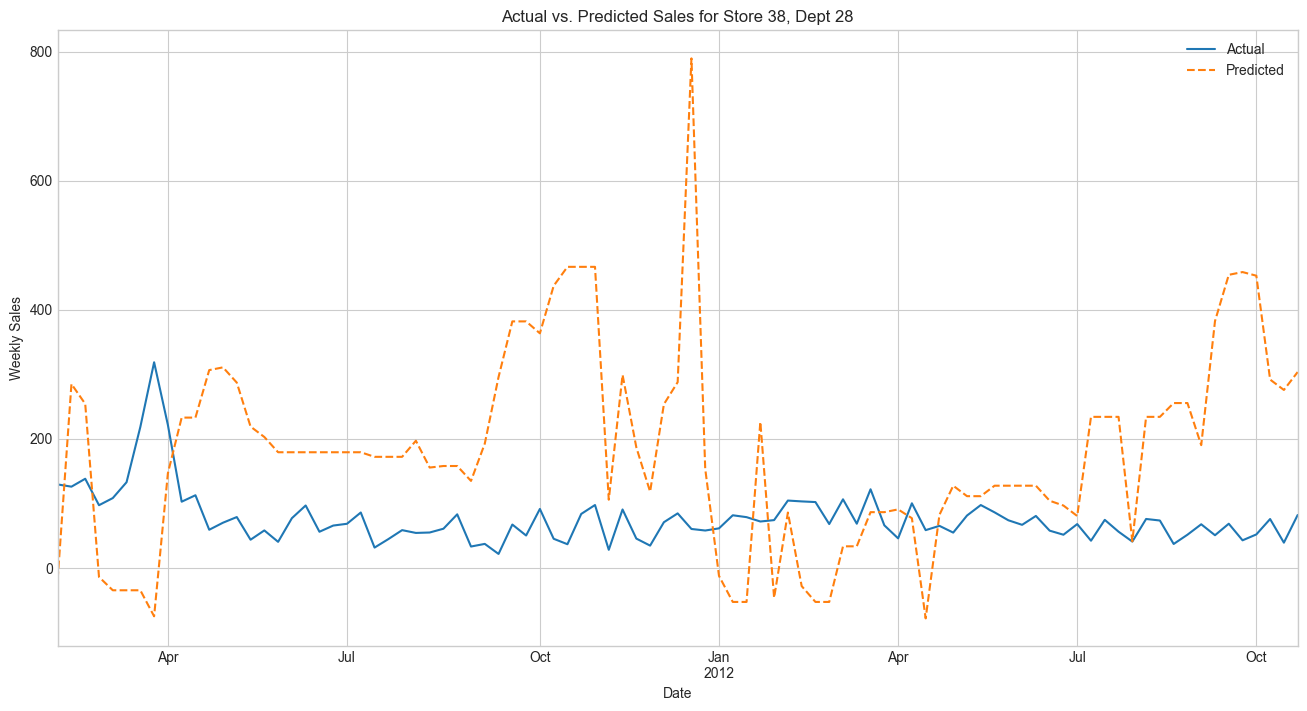

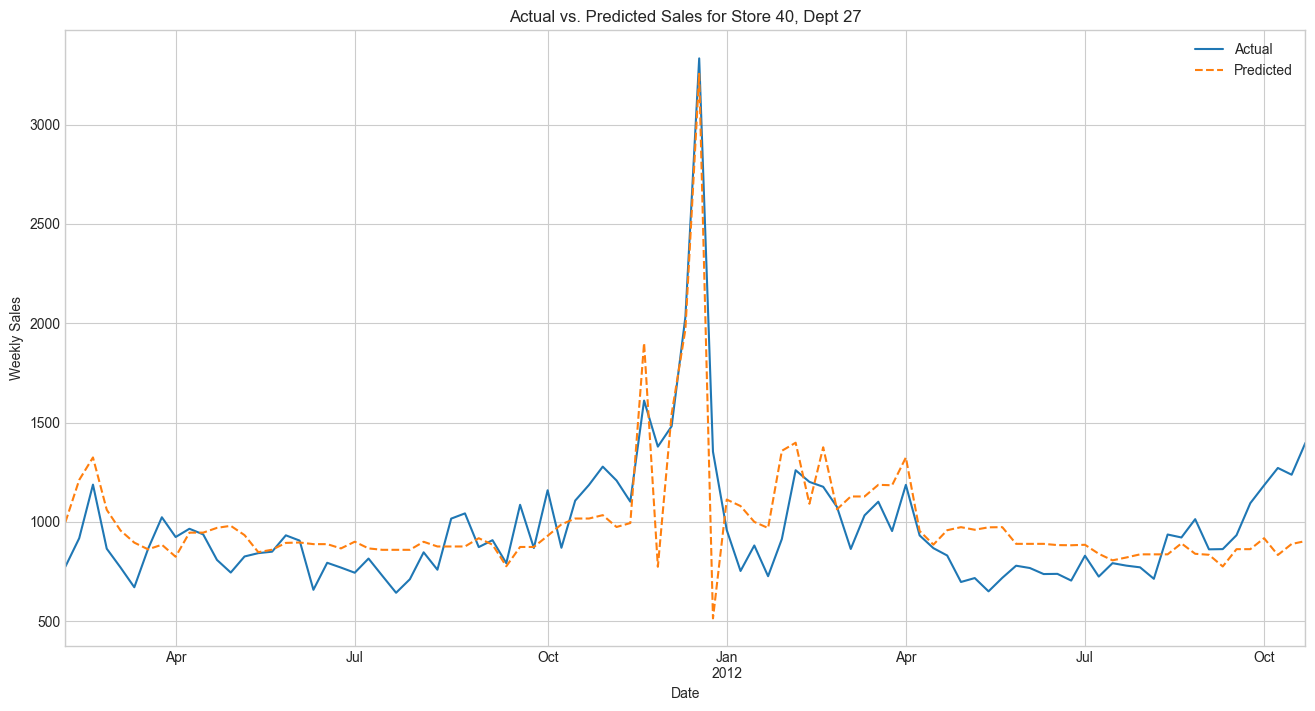

In [66]:
# Configure parameters for flexible analysis
MIN_ROW_COUNT = 90  # Minimum number of data points required
TOP_N = 10          # Number of best performers to show

# Filter combinations with sufficient data points
sufficient_data = final_stats[final_stats['RowCount'] >= MIN_ROW_COUNT]

# Check if we have enough combinations that meet the criteria
available_combinations = len(sufficient_data)
print(f"Store/Dept combinations with at least {MIN_ROW_COUNT} rows: {available_combinations}")

if available_combinations == 0:
    print(f"⚠️ No combinations found with at least {MIN_ROW_COUNT} rows.")
    print("Showing all available combinations instead:")
    best_performers = final_stats.nsmallest(TOP_N, 'RMSE')
elif available_combinations < TOP_N:
    print(f"⚠️ Only {available_combinations} combinations meet the criteria.")
    print(f"Showing all {available_combinations} combinations:")
    best_performers = sufficient_data.nsmallest(available_combinations, 'RMSE')
else:
    print(f"✅ Found sufficient combinations. Showing top {TOP_N}.")
    best_performers = sufficient_data.nsmallest(TOP_N, 'RMSE')

print(f"\nTop {len(best_performers)} Best Performing Store/Dept Combinations (Lowest RMSE, Min {MIN_ROW_COUNT} rows):")
print("=" * 80)
for (store, dept), row in best_performers.iterrows():
    print(f"Store {int(store):2d}, Dept {int(dept):2d}: RMSE = {row['RMSE']:6.2f}, Row Count = {int(row['RowCount']):3d}")

print(f"\nPlotting actual vs predicted sales for the top {len(best_performers)} performers...")

# Plot each of the best performers
for (store, dept), row in best_performers.iterrows():
    plot_sales_for_store_dept(results_df, store, dept)
